Cell 1: Đọc và xử lý dữ liệu, chuẩn bị feature

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "../../../Dataset/Splits/train_60_20_20.csv"
VAL_FILE   = "../../../Dataset/Splits/val_60_20_20.csv"
TEST_FILE  = "../../../Dataset/Splits/test_60_20_20.csv"

train_df = pd.read_csv(TRAIN_FILE, parse_dates=["Date"])
val_df = pd.read_csv(VAL_FILE, parse_dates=["Date"])
test_df = pd.read_csv(TEST_FILE, parse_dates=["Date"])

def parse_value(x):
    if isinstance(x, str):
        s = x.replace('$','').replace(',','')
        if s.endswith('%'): return float(s[:-1])
        if s.endswith('K'): return float(s[:-1]) * 1e3
        if s.endswith('M'): return float(s[:-1]) * 1e6
        return float(s)
    return x

def clean_df(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(parse_value)
    return df

train_df = clean_df(train_df)
val_df = clean_df(val_df)
test_df = clean_df(test_df)

df_all = pd.concat([train_df, val_df, test_df]).sort_values("Date").reset_index(drop=True)

# Thay NaN ở cột Vol. bằng giá trị trung bình
vol_mean = df_all['Vol.'].mean()
df_all['Vol.'].fillna(vol_mean, inplace=True)

# Tạo các thuộc tính mới (nếu bạn muốn giữ)
df_all["day_of_week"] = df_all["Date"].dt.dayofweek
df_all["month"] = df_all["Date"].dt.month
df_all["rolling_mean_5"] = df_all["Price"].rolling(window=5).mean()
df_all["rolling_std_5"] = df_all["Price"].rolling(window=5).std()
df_all["return_1d"] = df_all["Price"].pct_change()

# Bỏ các dòng vẫn còn NaN (do rolling, pct_change)
df_all.dropna(inplace=True)

feature_cols = ["Price", "Open", "High", "Low", "Vol.", "Change %", "CPIAUCSL",
                "day_of_week", "month", "rolling_mean_5", "rolling_std_5", "return_1d"]

scaler = StandardScaler()
df_all[feature_cols] = scaler.fit_transform(df_all[feature_cols])


C:\Users\quyen\AppData\Local\Temp\ipykernel_17768\3509247778.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Vol.'].fillna(vol_mean, inplace=True)


Cell 2: Chuẩn bị dữ liệu chuỗi (lagged) và feature tóm tắt cho MLP

In [4]:
SEQ_LEN = 90

def create_multivariate_lagged(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])
        y.append(data[i, 0])  # target Price
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(df_all[feature_cols].values, SEQ_LEN)

def create_summary_features(data, window, summary_cols_idx):
    summary_X = []
    for i in range(window, len(data)):
        summary_X.append(data[i-1, summary_cols_idx])
    return np.array(summary_X)

summary_feature_names = ["rolling_mean_5", "rolling_std_5", "return_1d"]
summary_cols_idx = [feature_cols.index(c) for c in summary_feature_names]

summary_features_all = create_summary_features(df_all[feature_cols].values, SEQ_LEN, summary_cols_idx)

n_train = len(train_df) - SEQ_LEN
n_val = len(val_df)

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train+n_val]
X_test = X_all[n_train+n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train+n_val]
y_test = y_all[n_train+n_val:]

summary_train = summary_features_all[:n_train]
summary_val = summary_features_all[n_train:n_train+n_val]
summary_test = summary_features_all[n_train+n_val:]


Cell 3: Tạo DataLoader PyTorch

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(summary_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
), batch_size=32, shuffle=False)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(summary_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
), batch_size=32)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(summary_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
), batch_size=32)


Cell 4: Định nghĩa mô hình WaveNet + MLP Hybrid

In [6]:
import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, dilation, in_ch, out_ch, kernel_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, dilation=dilation, padding='same')
        self.relu = nn.ReLU()
        self.skip = nn.Conv1d(out_ch, in_ch, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv(x))
        skip = self.skip(out)
        if skip.size(2) != x.size(2):
            min_len = min(skip.size(2), x.size(2))
            x = x[:, :, :min_len]
            skip = skip[:, :, :min_len]
        return x + skip, skip

class WaveNet(nn.Module):
    def __init__(self, in_ch, out_ch=32, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(d, in_ch, out_ch) for d in dilations
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, channels, seq_len)
        skip_total = None
        for block in self.blocks:
            x, skip = block(x)
            skip_total = skip if skip_total is None else skip_total + skip
        x = self.dropout(skip_total)
        x = x.mean(dim=2)  # global average pooling over seq_len
        return self.fc(x).squeeze(1)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class WaveNetMLPHybrid(nn.Module):
    def __init__(self, wavenet_in_ch, mlp_in_ch, mlp_hidden=32):
        super().__init__()
        self.wavenet = WaveNet(wavenet_in_ch)
        self.mlp = MLP(mlp_in_ch, mlp_hidden)
        self.fc = nn.Linear(1 + mlp_hidden, 1)

    def forward(self, x_seq, x_summary):
        w_out = self.wavenet(x_seq)  # (batch,)
        m_out = self.mlp(x_summary)  # (batch, mlp_hidden)
        combined = torch.cat([w_out.unsqueeze(1), m_out], dim=1)
        return self.fc(combined).squeeze(1)


Cell 5: Khởi tạo model, optimizer, loss

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNetMLPHybrid(wavenet_in_ch=X_train.shape[2], mlp_in_ch=summary_train.shape[1]).to(device)

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Cell 6: Huấn luyện model

In [8]:
from tqdm import tqdm

EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_seq_batch, X_sum_batch, y_batch in train_loader:
        X_seq_batch, X_sum_batch, y_batch = X_seq_batch.to(device), X_sum_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_seq_batch, X_sum_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_seq_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_seq_batch, X_sum_batch, y_batch in val_loader:
            X_seq_batch, X_sum_batch, y_batch = X_seq_batch.to(device), X_sum_batch.to(device), y_batch.to(device)
            y_pred = model(X_seq_batch, X_sum_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_seq_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_wavenet_mlp.pt")


c:\Users\quyen\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


Epoch 01 | Train Loss: 0.412653 | Val Loss: 0.515542
Epoch 02 | Train Loss: 0.291033 | Val Loss: 0.555250
Epoch 03 | Train Loss: 0.202986 | Val Loss: 0.573565
Epoch 04 | Train Loss: 0.143391 | Val Loss: 0.556714
Epoch 05 | Train Loss: 0.110782 | Val Loss: 0.501355
Epoch 06 | Train Loss: 0.092165 | Val Loss: 0.426252
Epoch 07 | Train Loss: 0.076432 | Val Loss: 0.350921
Epoch 08 | Train Loss: 0.062581 | Val Loss: 0.282758
Epoch 09 | Train Loss: 0.051084 | Val Loss: 0.223530
Epoch 10 | Train Loss: 0.041854 | Val Loss: 0.174019
Epoch 11 | Train Loss: 0.034701 | Val Loss: 0.134276
Epoch 12 | Train Loss: 0.029582 | Val Loss: 0.104186
Epoch 13 | Train Loss: 0.025944 | Val Loss: 0.082826
Epoch 14 | Train Loss: 0.023371 | Val Loss: 0.068961
Epoch 15 | Train Loss: 0.021601 | Val Loss: 0.060232
Epoch 16 | Train Loss: 0.020398 | Val Loss: 0.054814
Epoch 17 | Train Loss: 0.019304 | Val Loss: 0.051449
Epoch 18 | Train Loss: 0.018352 | Val Loss: 0.049074
Epoch 19 | Train Loss: 0.017585 | Val Loss: 0.

Cell 7: Đánh giá trên test set

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.load_state_dict(torch.load("best_wavenet_mlp.pt"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for X_seq_batch, X_sum_batch, y_batch in test_loader:
        X_seq_batch, X_sum_batch = X_seq_batch.to(device), X_sum_batch.to(device)
        y_pred = model(X_seq_batch, X_sum_batch).cpu().numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

mae = mean_absolute_error(y_trues, y_preds)
rmse = mean_squared_error(y_trues, y_preds)
mape = np.mean(np.abs((y_trues - y_preds) / y_trues)) * 100
r2 = r2_score(y_trues, y_preds)
n = len(y_trues)
p = X_train.shape[2]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R²        : {r2:.4f}")
print(f"Adj R²    : {adj_r2:.4f}")


MAE       : 0.5819
RMSE      : 0.5722
MAPE      : 35.61%
R²        : 0.3500
Adj R²    : 0.3397


Cell 8: Dự báo 90 ngày tương lai

In [10]:
model.eval()
input_seq = torch.tensor(X_test[-1:], dtype=torch.float32).to(device)
input_sum = torch.tensor(summary_test[-1:], dtype=torch.float32).to(device)

forecast_scaled = []

with torch.no_grad():
    for _ in range(90):
        y_next = model(input_seq, input_sum).cpu().item()
        forecast_scaled.append(y_next)

        # Cập nhật chuỗi đầu vào
        new_input_seq = input_seq[:, 1:, :].clone()
        new_step_seq = new_input_seq[:, -1:, :].clone()
        new_step_seq[:, :, 0] = y_next  # cập nhật Price mới
        input_seq = torch.cat([new_input_seq, new_step_seq], dim=1)

        # Cập nhật feature summary (giữ nguyên)
        input_sum = input_sum.clone()

forecast = np.array(forecast_scaled) * scaler.scale_[0] + scaler.mean_[0]


Cell 9: Vẽ biểu đồ kết quả

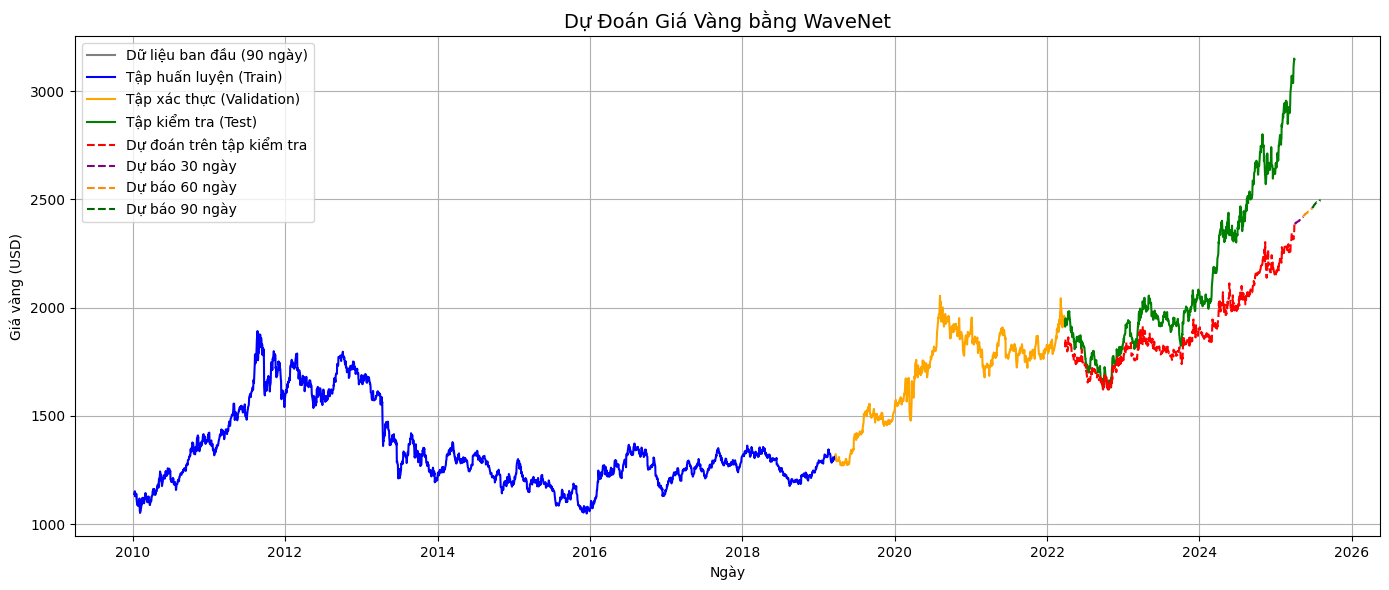

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import BDay

target_col = "Price"

train_len = len(train_df)
val_len = len(val_df)
start_idx = train_len + val_len

# Lấy ngày test từ df_all
test_dates = df_all['Date'].iloc[start_idx:start_idx + len(y_trues)].reset_index(drop=True)

# Chuẩn hóa ngược y_true và y_pred về giá trị gốc
y_trues_rescaled = y_trues * scaler.scale_[0] + scaler.mean_[0]
y_preds_rescaled = y_preds * scaler.scale_[0] + scaler.mean_[0]

plt.figure(figsize=(14, 6))

# Dữ liệu thực tế từng tập
plt.plot(df_all['Date'][:90], df_all[target_col].values[:90]*scaler.scale_[0] + scaler.mean_[0], color='gray', label='Dữ liệu ban đầu (90 ngày)')
plt.plot(df_all['Date'][:train_len], df_all[target_col].values[:train_len]*scaler.scale_[0] + scaler.mean_[0], color='blue', label='Tập huấn luyện (Train)')
plt.plot(df_all['Date'][train_len:train_len+val_len], df_all[target_col].values[train_len:train_len+val_len]*scaler.scale_[0] + scaler.mean_[0], color='orange', label='Tập xác thực (Validation)')
plt.plot(df_all['Date'][start_idx:], df_all[target_col].values[start_idx:]*scaler.scale_[0] + scaler.mean_[0], color='green', label='Tập kiểm tra (Test)')

# Dự đoán trên test
plt.plot(test_dates, y_preds_rescaled, color='red', linestyle='--', label='Dự đoán trên tập kiểm tra')

# Vẽ forecast 30/60/90 ngày nếu có
try:
    last_test_date = pd.to_datetime(test_dates.iloc[-1])
    full_forecast = np.concatenate([y_preds_rescaled[-1:], forecast])  # forecast là mảng dự báo tương lai
    full_dates = pd.date_range(last_test_date, periods=len(full_forecast), freq=BDay())

    plt.plot(full_dates[1:31], full_forecast[1:31], color='purple', linestyle='--', label='Dự báo 30 ngày')
    plt.plot(full_dates[31:61], full_forecast[31:61], color='darkorange', linestyle='--', label='Dự báo 60 ngày')
    plt.plot(full_dates[61:], full_forecast[61:], color='darkgreen', linestyle='--', label='Dự báo 90 ngày')
except NameError:
    pass  # Nếu forecast chưa được định nghĩa thì bỏ qua

plt.title("Dự Đoán Giá Vàng bằng WaveNet", fontsize=14)
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
!jupyter nbconvert --to html WaveNet_MLP_60-20-20.ipynb

[NbConvertApp] Converting notebook WaveNet_MLP_60-20-20.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 465770 bytes to WaveNet_MLP_60-20-20.html
